<a href="https://colab.research.google.com/github/BhumikaAdhya05/JU_Research/blob/main/PANet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"bhumikaadhya05","key":"76f7c91a508c639053f3ec8ca5a655a0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d orvile/bus-uclm-breast-ultrasound-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/bus-uclm-breast-ultrasound-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 629M/642M [00:06<00:00, 139MB/s]
100% 642M/642M [00:06<00:00, 98.0MB/s]


In [ ]:
import zipfile
import os

with zipfile.ZipFile("bus-uclm-breast-ultrasound-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [ ]:
for root, dirs, files in os.walk('./data'):
    print(root, "->", len(files), "files")

./data -> 0 files
./data/bus_uclm_separated -> 0 files
./data/bus_uclm_separated/benign -> 174 files
./data/bus_uclm_separated/malign -> 90 files
./data/bus_uclm_separated/normal -> 419 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset -> 0 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset -> 0 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM -> 1 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/masks -> 683 files
./data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/images -> 683 files


In [ ]:
import cv2
import numpy as np
import os
import random
from glob import glob
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T

In [ ]:
IMG_DIR = './data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/images'
MASK_DIR = './data/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM Breast ultrasound lesion segmentation dataset/BUS-UCLM/masks'

image_paths = sorted(glob(os.path.join(IMG_DIR, '*.png')))
mask_paths = sorted(glob(os.path.join(MASK_DIR, '*.png')))

print(f"Total images: {len(image_paths)}, Total masks: {len(mask_paths)}")

Total images: 683, Total masks: 683


In [ ]:
def preprocess_image(path, size=256):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)     # Add channel dim (1, H, W)
    return img

def preprocess_mask(path, size=256):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (size, size))
    mask = (mask > 0).astype(np.float32)  # Binarize
    mask = np.expand_dims(mask, axis=0)
    return mask

In [ ]:
def is_valid_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return np.sum(mask) > 0

def get_episode(n_shot=1):
    """Sample N-shot episode: support + query, all with non-empty masks"""
    valid_indices = [i for i, p in enumerate(mask_paths) if is_valid_mask(p)]

    random.shuffle(valid_indices)

    support_images = []
    support_masks = []

    for i in valid_indices[:n_shot]:
        support_images.append(preprocess_image(image_paths[i]))
        support_masks.append(preprocess_mask(mask_paths[i]))

    # Query image should also have a valid mask
    query_index = valid_indices[n_shot]
    query_image = preprocess_image(image_paths[query_index])
    query_mask = preprocess_mask(mask_paths[query_index])

    support_images = torch.tensor(np.stack(support_images), dtype=torch.float32)
    support_masks = torch.tensor(np.stack(support_masks), dtype=torch.float32)
    query_image = torch.tensor(query_image, dtype=torch.float32)
    query_mask = torch.tensor(query_mask, dtype=torch.float32)

    return support_images, support_masks, query_image, query_mask

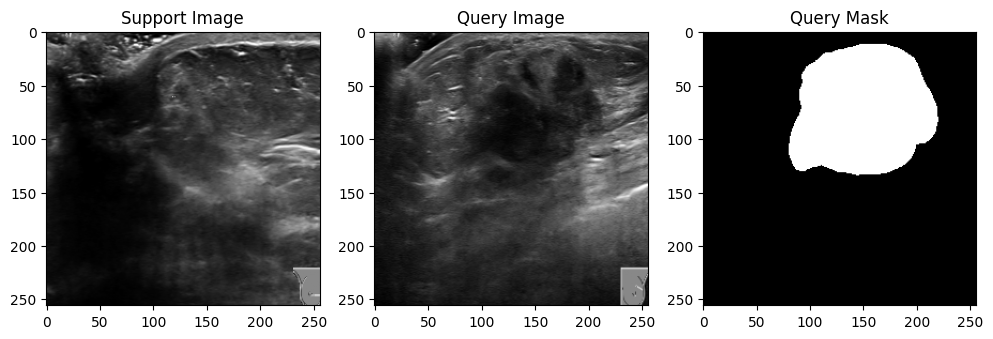

In [ ]:
support_images, support_masks, query_image, query_mask = get_episode(n_shot=1)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(support_images[0][0], cmap='gray')
plt.title('Support Image')

plt.subplot(1, 3, 2)
plt.imshow(query_image[0], cmap='gray')
plt.title('Query Image')

plt.subplot(1, 3, 3)
plt.imshow(query_mask[0], cmap='gray')
plt.title('Query Mask')
plt.show()

In [ ]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F
import matplotlib.pyplot as plt

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract only the feature layers (remove FC & avgpool)
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,  # Output: (B, 1024, H/16, W/16)
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
def compute_prototype(support_feats, support_masks):
    """
    support_feats: (N, C, H, W)
    support_masks: (N, 1, H, W)
    Returns: prototype vector (1, C)
    """
    N, C, H, W = support_feats.shape

    # Resize masks to match feature size
    support_masks = nn.functional.interpolate(support_masks, size=(H, W), mode='nearest')

    # Apply mask to features
    masked_feats = support_feats * support_masks  # (N, C, H, W)
    sum_feats = masked_feats.sum(dim=(2, 3))       # (N, C)
    pixel_count = support_masks.sum(dim=(2, 3)).clamp(min=1e-6)  # (N, 1)

    prototype = sum_feats / pixel_count  # (N, C)
    prototype = prototype.mean(dim=0, keepdim=True)  # (1, C)
    return prototype

In [ ]:
def cosine_similarity(query_feats, prototype):
    proto = prototype.view(1, -1, 1, 1)
    sim = F.cosine_similarity(query_feats, proto, dim=1).unsqueeze(1)  # (1, 1, H, W)
    return sim

In [ ]:
support_images, support_masks, query_image, query_mask = get_episode(n_shot=1)

# 5. Convert 1-channel grayscale → 3-channel RGB
support_images = support_images.repeat(1, 3, 1, 1)                    # (N, 3, H, W)
query_image = query_image.unsqueeze(0).repeat(1, 3, 1, 1)             # (1, 3, H, W)
query_mask = query_mask.unsqueeze(0)                                  # (1, 1, H, W)

support_images, support_masks = support_images.to(device), support_masks.to(device)
query_image, query_mask = query_image.to(device), query_mask.to(device)

In [ ]:
extractor = FeatureExtractor().to(device).eval()
with torch.no_grad():
    support_feats = extractor(support_images)  # (N, C, H', W')
    query_feats = extractor(query_image)       # (1, C, H', W')

    prototype = compute_prototype(support_feats, support_masks)  # (1, C)
    sim_map = cosine_similarity(query_feats, prototype)          # (1, 1, H', W')

    sim_map = F.interpolate(sim_map, size=(256, 256), mode='bilinear', align_corners=False)
    sim_map = sim_map.squeeze().cpu().numpy()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


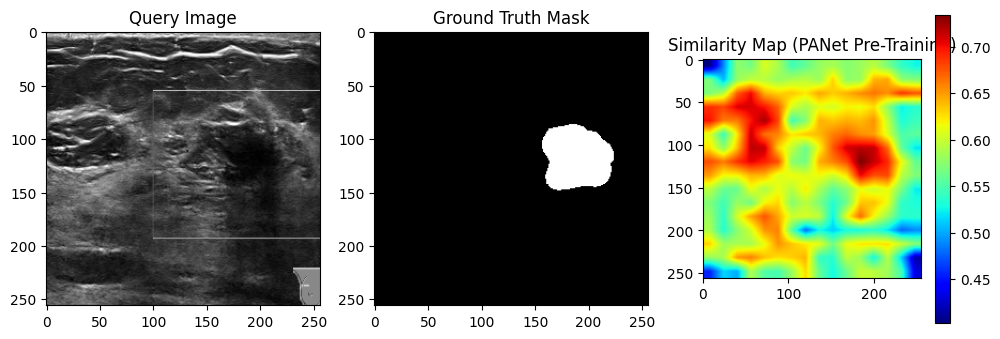

In [ ]:
# 8. Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(query_image.squeeze().cpu()[0], cmap='gray')
plt.title("Query Image")

plt.subplot(1, 3, 2)
plt.imshow(query_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(sim_map, cmap='jet')
plt.title("Similarity Map (PANet Pre-Training)")
plt.colorbar()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,  # Output: (B, 1024, H/16, W/16)
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
def compute_prototype(support_feats, support_masks):
    """
    support_feats: (N, C, H, W)
    support_masks: (N, 1, H, W)
    """
    N, C, H, W = support_feats.shape
    masked_feats = []

    for i in range(N):
        feat_i = support_feats[i]        # (C, H, W)
        mask_i = support_masks[i]        # (1, H, W)

        # Resize mask to match feature map size if needed
        if mask_i.shape[-2:] != feat_i.shape[-2:]:
            mask_i = F.interpolate(mask_i.unsqueeze(0), size=(H, W), mode='nearest').squeeze(0)  # (1, H, W)

        fg = mask_i.squeeze(0) > 0.5     # (H, W) — foreground mask

        if fg.sum() == 0:
            continue  # skip empty masks

        feat_fg = feat_i[:, fg]          # (C, num_fg_pixels)
        proto_vec = feat_fg.mean(dim=1)  # (C,)
        masked_feats.append(proto_vec)

    if not masked_feats:
        # If no foreground pixels in any shot
        return torch.zeros(1, C).to(support_feats.device)

    prototype = torch.stack(masked_feats).mean(dim=0, keepdim=True)  # (1, C)
    return prototype

In [ ]:
prototype = compute_prototype(support_feats, support_masks)
prototype = F.normalize(prototype, p=2, dim=1)
print("Prototype norm:", prototype.norm().item())

Prototype norm: 0.9999999403953552


In [ ]:
def cosine_similarity(query_feats, prototype):
    proto = prototype.view(1, -1, 1, 1)  # (1, C, 1, 1)
    sim_map = F.cosine_similarity(query_feats, proto, dim=1).unsqueeze(1)  # (1, 1, H, W)
    return sim_map

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class PANet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, support_images, support_masks, query_image):
        # 3-channel input assumed
        support_feats = self.encoder(support_images)
        support_feats = F.normalize(support_feats, p=2, dim=1)         # (N, C, H, W)
        query_feats = self.encoder(query_image)
        query_feats = F.normalize(query_feats, p=2, dim=1)              # (1, C, H, W)

        prototype = compute_prototype(support_feats, support_masks)
        prototype = F.normalize(prototype, p=2, dim=1)  # (1, C)
        sim_map = cosine_similarity(query_feats, prototype)          # (1, 1, H, W)

        sim_map = F.interpolate(sim_map, size=(256, 256), mode='bilinear', align_corners=False)
        pred_mask = self.decoder(sim_map)                             # (1, 1, 256, 256)

        return pred_mask, sim_map

In [ ]:
panet = PANet().to(device).eval()

In [ ]:
# Get a 1-shot episode
support_images, support_masks, query_image, query_mask = get_episode(n_shot=1)

# Convert 1-channel → 3-channel
support_images = support_images.repeat(1, 3, 1, 1)  # [N, 3, 256, 256]
query_image = query_image.unsqueeze(0).repeat(1, 3, 1, 1)  # [1, 3, 256, 256]
query_mask = query_mask.unsqueeze(0)  # [1, 1, 256, 256]

# Move to device
support_images = support_images.to(device)
support_masks = support_masks.to(device)
query_image = query_image.to(device)
query_mask = query_mask.to(device)

# Run forward pass
with torch.no_grad():
    pred_mask, sim_map = panet(support_images, support_masks, query_image)
    pred_mask = pred_mask.squeeze().cpu().numpy()
    query_img = query_image.squeeze().cpu()[0].numpy()
    true_mask = query_mask.squeeze().cpu().numpy()
    sim_map = sim_map.squeeze().cpu().numpy()

In [ ]:
print("Sim Map range:", sim_map.min().item(), sim_map.max().item())

Sim Map range: 0.40181800723075867 0.8107283115386963


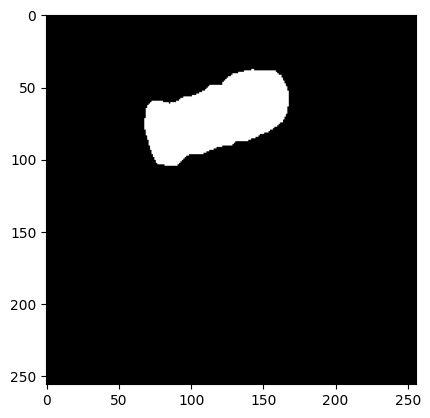

In [ ]:
plt.imshow(query_mask.squeeze().cpu().numpy(), cmap='gray')

In [ ]:
print("Support mask unique:", torch.unique(support_masks))

Support mask unique: tensor([0., 1.], device='cuda:0')


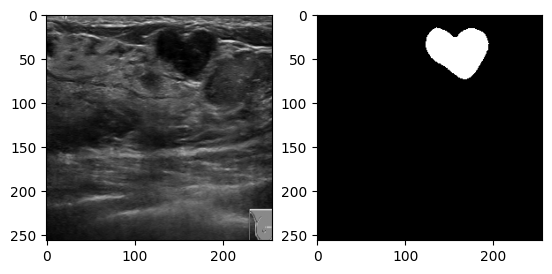

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(support_images[0][0].cpu(), cmap='gray')
ax[1].imshow(support_masks[0][0].cpu(), cmap='gray')

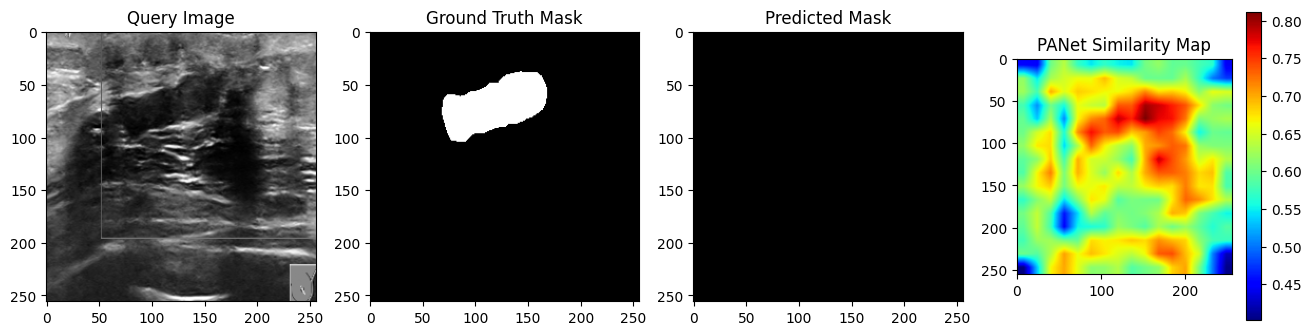

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(query_img, cmap='gray')
plt.title("Query Image")

plt.subplot(1, 4, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask > 0.3, cmap='gray')
plt.title("Predicted Mask")

plt.subplot(1, 4, 4)
plt.imshow(sim_map, cmap='jet')
plt.title("PANet Similarity Map")
plt.colorbar()
plt.show()

In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [ ]:
import torch.optim as optim

# Model
panet = PANet().to(device)

# Optimizer
optimizer = optim.Adam(panet.parameters(), lr=5e-5)

# Loss functions
bce = nn.BCEWithLogitsLoss()

In [ ]:
from tqdm import tqdm

num_episodes = 200

for episode in tqdm(range(num_episodes)):
    panet.train()

    support_images, support_masks, query_image, query_mask = get_episode(n_shot=1)

    support_images = support_images.repeat(1, 3, 1, 1).to(device)  # (5, 3, H, W)
    query_image = query_image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)
    support_masks = support_masks.to(device)                      # (5, 1, H, W)
    query_mask = query_mask.unsqueeze(0).to(device)

    pred_mask, _ = panet(support_images, support_masks, query_image)

    loss_dice = dice_loss(torch.sigmoid(pred_mask), query_mask)
    loss_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
    total_loss = loss_dice + 0.7 * loss_bce

    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(panet.parameters(), max_norm=1.0)
    optimizer.step()

    if (episode + 1) % 20 == 0:
        print(f"\nEpisode {episode+1}/{num_episodes} | Loss: {total_loss.item():.4f}")
        panet.eval()
        with torch.no_grad():
            pred_vis = torch.sigmoid(pred_mask)
            true_mask = query_mask.squeeze().cpu().numpy()
            query_img = query_image.squeeze().cpu()[0].numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(query_img, cmap='gray')
        plt.title("Query Image")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_vis.squeeze().cpu().numpy() > 0.3, cmap='gray')
        plt.title("PANet Prediction")
        plt.show()

        print(f"Prediction mean (after sigmoid): {torch.sigmoid(pred_mask).mean().item():.4f}")
        print(f"Prototype norm: {prototype.norm().item():.4f}")
        plt.imshow(sim_map.squeeze().cpu().numpy(), cmap='viridis')

  0%|          | 0/200 [00:03<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'float' and 'BCEWithLogitsLoss'